In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import joblib
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle

In [78]:
df = pd.read_csv('/kaggle/input/shoe-data/sneakers_Reviews_Dataset.csv', sep =';')

In [79]:
df.head()

,review_id,product_id,user_id,rating,review_text,timestamp
0,1,103,16074,3,"Comfortable, but not durable.",2022/11/07 05:30
1,2,436,11648,4,Highly recommend!,2021/09/11 02:53
2,3,861,46508,2,Do not recommend.,2022/12/14 13:24
3,4,271,40094,3,"Comfortable, but not durable.",2021/11/29 04:01
4,5,107,49897,4,Will buy again.,2023/04/24 12:12


In [80]:
import matplotlib.pyplot as plt

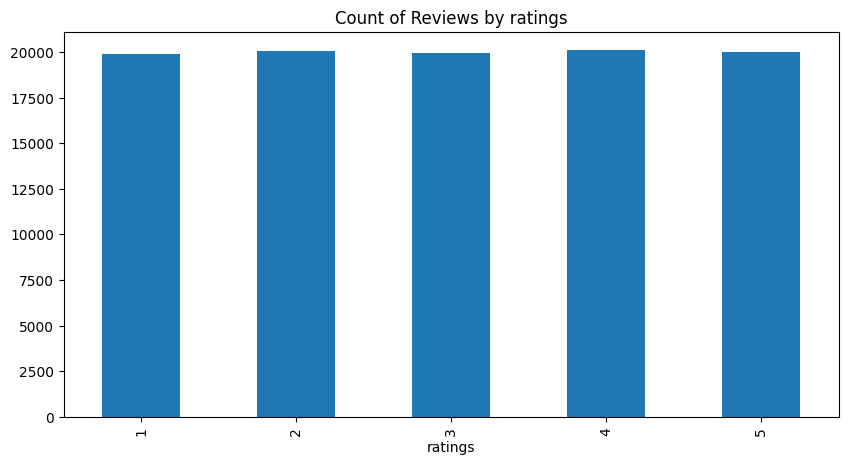

In [81]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by ratings',
          figsize=(10, 5))
ax.set_xlabel('ratings')
plt.show()

In [82]:
df['rating'].value_counts()

rating
4    20096
2    20066
5    20006
3    19924
1    19908
Name: count, dtype: int64

In [83]:
df['review_text'].value_counts()

review_text
I love these sneakers.           8111
Will buy again.                  8082
Do not recommend.                8067
Falling apart after a week.      8035
Very uncomfortable.              8009
Highly recommend!                7984
Poor quality!                    7970
Great quality!                   7966
Very comfortable.                7959
Waste of money.                  7893
Average sneakers.                5078
Decent quality.                  4965
Comfortable, but not durable.    4960
They are okay.                   4921
Name: count, dtype: int64

In [84]:
df['review_text'] = df['review_text'].str.lower()

In [85]:
def rem_punc(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [86]:
df['review_text'] = df['review_text'].apply(rem_punc)

In [87]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [88]:
df['tokenized_text'] = df['review_text'].apply(word_tokenize)

In [89]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [90]:
lem = WordNetLemmatizer()
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [lem.lemmatize(word) for word in x])

In [91]:
df['tokenized_text'] = df['tokenized_text'].apply(lambda tokens: ' '.join(tokens))

In [92]:
df['review_text'] = df['review_text']
df.drop(columns=['tokenized_text'], inplace=True)

In [110]:
sent_map = {
    1: 'negative',
    2: 'negative',
    3: 'neutral',
    4: 'positive',
    5: 'positive'
}

# Map ratings to sentiment labels
df['sentiment'] = df['rating'].map(sent_map)

# Display the DataFrame with sentiment labels
df.head()

,review_id,product_id,user_id,rating,review_text,timestamp,sentiment
0,1,103,16074,3,comfortable but not durable,2022/11/07 05:30,neutral
1,2,436,11648,4,highly recommend,2021/09/11 02:53,positive
2,3,861,46508,2,do not recommend,2022/12/14 13:24,negative
3,4,271,40094,3,comfortable but not durable,2021/11/29 04:01,neutral
4,5,107,49897,4,will buy again,2023/04/24 12:12,positive


In [111]:
tfidf_vectorizer = TfidfVectorizer(max_features=1500) 
X = tfidf_vectorizer.fit_transform(df['review_text'])

In [112]:
y = df['sentiment']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters to search, including solver and penalty
param_grid = {
    'solver': ['saga'],  
    'penalty': ['l1'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Create a logistic regression model
model = LogisticRegression(solver='saga', tol=1e-4, max_iter = 500)

# Use grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_model = grid_search.best_estimator_

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

In [120]:
best_model.fit(X_train, y_train)

LogisticRegression(C=0.001, penalty='l1', solver='saga')

In [103]:
y_pred = best_model.predict(X_test)

In [104]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='weighted')

In [105]:
print(f'Accuracy: {accuracy:.2f}')
print(f'precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'f1 Score: {f1:.2f}')

Accuracy: 1.00
precision: 1.00
Recall: 1.00
f1 Score: 1.00
